# Part 4: CLIP Image-Vision Transformer

In this part of the assignment, you'll dive into using the CLIP model. CLIP is a transformer model built by OpenAI designed to leverage the relationships of both images and text to improve understanding and interpretation. It is a *multimodal* model, in the sense that it takes both text and images as inputs. You can [read more about CLIP here.](https://openai.com/index/clip/).

You won't need to implement the model structure from scratch. Instead, you'll leverage a pre-trained CLIP model for image classification. What is particularly interesting is that CLIP is not trained to predict any particular image labels: Rather, you can provide an arbitrary set of text labels and CLIP will try to predict a score for each text label given to consider as input. You will consider designing better text label prompts to improve performance, a process often referred to as [prompt engineering](https://www.promptingguide.ai/).

### Learning Objectives

Through this exercise, you will:
1. **Run** a pre-trained multimodal CLIP model on a sample image and examine the output.
2. **Evaluate** the model's accuracy for classification.
3. **Experiment** with prompt engineering techniques to optimize the model's classification accuracy.

While it is possible to complete this assignment using CPU compute, it may be slow. To accelerate your training, consider using GPU resources such as `CUDA` through the CS department cluster. Alternatives include Google colab or local GPU resources for those running on machines with GPU support.

Below we download the CLIP model, its preprocessor (which takes care of tokenization for the text input and image preprocessing for the image input), and the Oxford pets dataset. The dataset consists of around 3,700 images of dogs or cats, with class labels broken down by the type/breed of dog or cat. Our goal will be to classify the breed of an image using CLIP.

The labels in the dataset are the indices into `class_names`, the list of breed names. We also define a `class_to_species` map defined for every breed to track whether that breed is a dog or cat, information that might come in handy later.

In [13]:
# Run but you do not need to modify this code

import os
import torch
from torchvision.datasets import CIFAR10, OxfordIIITPet
from transformers import CLIPProcessor, CLIPModel
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
model.to(device)
preprocess = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

pets = OxfordIIITPet(root=os.path.expanduser("~/.cache"), download=True, split="test")
class_names = pets.classes
class_to_species = {
    # Cats
    'Abyssinian': 'cat', 'Bengal': 'cat', 'Birman': 'cat', 'Bombay': 'cat',
    'British Shorthair': 'cat', 'Egyptian Mau': 'cat', 'Maine Coon': 'cat',
    'Persian': 'cat', 'Ragdoll': 'cat', 'Russian Blue': 'cat', 'Siamese': 'cat',
    'Sphynx': 'cat',
    # Dogs
    'American Bulldog': 'dog', 'American Pit Bull Terrier': 'dog', 'Basset Hound': 'dog',
    'Beagle': 'dog', 'Boxer': 'dog', 'Chihuahua': 'dog', 'English Cocker Spaniel': 'dog', 
    'English Setter': 'dog', 'German Shorthaired': 'dog', 'Great Pyrenees': 'dog',
    'Havanese': 'dog', 'Japanese Chin': 'dog', 'Keeshond': 'dog', 'Leonberger': 'dog',
    'Miniature Pinscher': 'dog', 'Newfoundland': 'dog', 'Pomeranian': 'dog', 'Pug': 'dog',
    'Saint Bernard': 'dog', 'Samoyed': 'dog', 'Scottish Terrier': 'dog', 'Shiba Inu': 'dog',
    'Staffordshire Bull Terrier': 'dog', 'Wheaten Terrier': 'dog', 'Yorkshire Terrier': 'dog',
    }

Using device: mps


Below we visualize the first image as an example.

0
Abyssinian


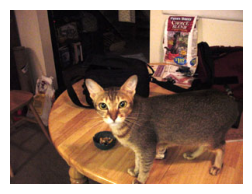

In [15]:
# Run, but you do not need to modify this code

import matplotlib.pyplot as plt

# Get the image and ground truth label for first image as an example
image, class_id = pets[0]
print(class_id)
print(class_names[class_id])
      
# Visualize the image
plt.figure(figsize=(3, 3))
plt.axis("off")
plt.imshow(image)
plt.show()

Now we demonstrate the use of the CLIP model on the example image shown above. Note that we pass list of strings for the `text` parameter, simply corresponding to the string names of the breeds. The `predict_class` function expects inputs encoded with the `CLIP` preprocessor as shown. It returns the label (an index into the `class_names` list) with the maximum output logit for the model across all the strings in the input `text`. In this case, it correctly identifies the image as an `Abyssinian` by returning index `0` (`Abyssinian` is the first element of `class_names`).

In [17]:
# Run, but you do not need to modify this code

def predict_class(model, inputs):
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image
    return torch.argmax(logits_per_image, dim=1).item()


example_inputs = preprocess(
    text=[c for c in class_names],
    images=image,
    return_tensors="pt",
    padding=True,
    )
example_inputs = {key: value.to(device) for key, value in example_inputs.items()}


print(predict_class(model, example_inputs))

0


## Task 1

In this part, your goal is to use CLIP to make predictions for the entire `pets` dataset and compute the overall accuracy of the predictions. You can use the relatively simple `text` prompting (just using the class names) as shown above. You should be able to get an accuracy of around 80%.

In [18]:
correct = 0
total = 0
# had to re-map the labels to class names
class_name_from_label = {i: class_names[i] for i in range(len(class_names))}

for image, label in pets:
    class_name = class_name_from_label[label]
    species = class_to_species[class_name]
    actual = class_names.index(class_name)
    example_inputs = preprocess(
        text=[c for c in class_names],
        images=image,
        return_tensors="pt",
        padding=True,
    )
    example_inputs = {key: value.to(device) for key, value in example_inputs.items()}
    pred = predict_class(model, example_inputs)
    if pred == actual:
        correct += 1
    total += 1

accuracy = correct / total
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.8005


## Task 2

Experiment with prompt engineering to improve the model's performance and achieve an accuracy of at least 87% on the dataset. By prompt engineering, we mean changing the `text` inputs to the model to provide more detail than just the class name. For examples:
- You might include some instruction prior to the class name such as "Picture of a: ", or "Photo of a pet with breed: "
- You might also incorporate some additional information to help the model understand each particular class name. For example, you might use the class_to_species map from above to supplement with information like ", which is a type of cat" when referring to a class name like Abyssinian

Show your final results including the calculation of the accuracy of the predictions on the dataset.

In [19]:
# todo: write your code for task 2 here
correct = 0
total = 0
# had to re-map the labels to class names
class_name_from_label = {i: class_names[i] for i in range(len(class_names))}

for image, label in pets:
    class_name = class_name_from_label[label]
    species = class_to_species[class_name]
    actual = class_names.index(class_name)
    example_inputs = preprocess(
        text=["Photo of a pet with breed: " + c + ", which is a type of " + species for c in class_names],
        images=image,
        return_tensors="pt",
        padding=True,
    )
    example_inputs = {key: value.to(device) for key, value in example_inputs.items()}
    pred = predict_class(model, example_inputs)
    if pred == actual:
        correct += 1
    total += 1

accuracy = correct / total
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.8771


## Task 3

We could, of course, have simply trained a convolutional neural network to classify the pet images in this task. In one or two paragraphs, explain why the CLIP model is a more general model and explain one or more applications you could imagine developing using a model of this form.

*Briefly explain for task 3 here*

The CLIP model is more general than a simple CNN for image classification because while a CNN finds patterns and relationships solely within images, the CLIP model learns the relationship between text and images. While a CNN might try to classify a pet by just looking at the body shape and other physical features, the CLIP model would also use the given description. This is also helpful for learning new classes. If you have an unseen class, such as a golden retriever, and you want the model to learn that type of pet, a CNN would have a more difficult time with this than a CLIP model. A CLIP model could easily do this since you could just give the image of the golden retriever and give the textual description, "Photo of a pet with breed: Golden Retriever, which is a type of dog.", and it would learn a relationship faster than a CNN would. Some use cases of the CLIP model could be searching the internet for images given a textual description, or creating meaningful captions for images.